# Library Imports

In [1]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from scipy.signal import argrelextrema, welch
from scipy.integrate import cumtrapz
import statistics
import time

import mne # to read the .edf files
import csv

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

In [3]:
from sklearn.utils.class_weight import compute_class_weight

# Preprocessing

In [4]:
# some pre-processing used function from pyeeg

def bin_power(X, Band, Fs):
    """Compute power in each frequency bin specified by Band from FFT result of

    Parameters
    -----------

    X: list: a 1-D real time series.
    Band; list
        boundary frequencies (in Hz) of bins. They can be unequal bins, e.g.
        [0.5,4,7,12,30] which are delta, theta, alpha and beta respectively.
        You can also use range() function of Python to generate equal bins and
        pass the generated list to this function.

        Each element of Band is a physical frequency and shall not exceed the
        Nyquist frequency, i.e., half of sampling frequency.



    Fs: integer: the sampling rate in physical frequency

    Returns
    -------

    Power: list: spectral power in each frequency bin.

    Power_ratio: list:
        spectral power in each frequency bin normalized by total power in ALL
        frequency bins.

    """

    C = np.fft.fft(X)
    C = abs(C)
    Power = np.zeros(len(Band) - 1)
    for Freq_Index in range(0, len(Band) - 1):
        Freq = float(Band[Freq_Index])
        Next_Freq = float(Band[Freq_Index + 1])
        Power[Freq_Index] = sum(
            C[int(np.floor(Freq / Fs * len(X))):
                int(np.floor(Next_Freq / Fs * len(X)))]
        )
    Power_Ratio = Power / sum(Power)
    return Power, Power_Ratio


def hfd(X, Kmax):
    """ Compute Higuchi Fractal Dimension of a time series X. kmax
     is an HFD parameter
    """
    L = []
    x = []
    N = len(X)
    for k in range(1, Kmax):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lmk += abs(X[m + i * k] - X[m + i * k - k])
            Lmk = Lmk * (N - 1) / np.floor((N - m) / float(k)) / k
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(float(1) / k), 1])

    (p, _, _, _) = np.linalg.lstsq(x, L)
    return p[0]



def pfd(X, D=None):
    """Compute Petrosian Fractal Dimension of a time series from either two
    cases below:
        1. X, the time series of type list (default)
        2. D, the first order differential sequence of X (if D is provided,
           recommended to speed up)

    In case 1, D is computed using Numpy's difference function.

    To speed up, it is recommended to compute D before calling this function
    because D may also be used by other functions whereas computing it here
    again will slow down.
    """
    if D is None:
        D = np.diff(X)
        D = D.tolist()
    N_delta = 0  # number of sign changes in derivative of the signal
    for i in range(1, len(D)):
        if D[i] * D[i - 1] < 0:
            N_delta += 1
    n = len(X)
    return np.log10(n) / (
        np.log10(n) + np.log10(n / n + 0.4 * N_delta)
    )


def hurst(X):
    """ Compute the Hurst exponent of X. If the output H=0.5,the behavior
    of the time-series is similar to random walk. If H<0.5, the time-series
    cover less "distance" than a random walk, vice verse.

    Parameters
    ----------

    X: list: a time series

    Returns
    -------
    H: float:  Hurst exponent
    """
    X = np.array(X)
    N = X.size
    T = np.arange(1, N + 1)
    Y = np.cumsum(X)
    Ave_T = Y / T

    S_T = np.zeros(N)
    R_T = np.zeros(N)

    for i in range(N):
        S_T[i] = np.std(X[:i + 1])
        X_T = Y - T * Ave_T[i]
        R_T[i] = np.ptp(X_T[:i + 1])

    R_S = R_T / S_T
    R_S = np.log(R_S)[1:]
    n = np.log(T)[1:]
    A = np.column_stack((n, np.ones(n.size)))
    [m, c] = np.linalg.lstsq(A, R_S)[0]
    H = m
    return H


def spectral_entropy(X, Band, Fs, Power_Ratio=None):
    """Compute spectral entropy of a time series from either two cases below:
    1. X, the time series (default)
    2. Power_Ratio, a list of normalized signal power in a set of frequency
    bins defined in Band (if Power_Ratio is provided, recommended to speed up)

    In case 1, Power_Ratio is computed by bin_power() function.

    Notes
    -----
    To speed up, it is recommended to compute Power_Ratio before calling this
    function because it may also be used by other functions whereas computing
    it here again will slow down.

    Parameters
    ----------

    X: list: a 1-D real time series.

    Band: list

        boundary frequencies (in Hz) of bins. They can be unequal bins, e.g.
        [0.5,4,7,12,30] which are delta, theta, alpha and beta respectively.
        You can also use range() function of Python to generate equal bins and
        pass the generated list to this function.

        Each element of Band is a physical frequency and shall not exceed the
        Nyquist frequency, i.e., half of sampling frequency.


    Fs: integer: the sampling rate in physical frequency

    Returns
    -------

    As indicated in return line

    See Also
    --------
    bin_power: pyeeg function that computes spectral power in frequency bins

    """

    if Power_Ratio is None:
        Power, Power_Ratio = bin_power(X, Band, Fs)

    Spectral_Entropy = 0
    for i in range(0, len(Power_Ratio) - 1):
        Spectral_Entropy += Power_Ratio[i] * np.log(Power_Ratio[i])
    Spectral_Entropy /= np.log(
        len(Power_Ratio)
    )  # to save time, minus one is omitted
    return -1 * Spectral_Entropy


def hjorth(X, D=None):
    """ Compute Hjorth mobility and complexity of a time series from either two
    cases below:
        1. X, the time series of type list (default)
        2. D, a first order differential sequence of X (if D is provided,
           recommended to speed up)

    In case 1, D is computed using Numpy's Difference function.

    Notes
    -----
    To speed up, it is recommended to compute D before calling this function
    because D may also be used by other functions whereas computing it here
    again will slow down.

    Parameters
    ----------

    X: list: a time series

    D: list: first order differential sequence of a time series

    Returns
    -------

    As indicated in return line

    Hjorth mobility and complexity

    """

    if D is None:
        D = np.diff(X)
        D = D.tolist()

    D.insert(0, X[0])  # pad the first difference
    D = np.array(D)

    n = len(X)

    M2 = float(sum(D ** 2)) / n
    TP = sum(np.array(X) ** 2)
    M4 = 0
    for i in range(1, len(D)):
        M4 += (D[i] - D[i - 1]) ** 2
    M4 = M4 / n

    return np.sqrt(M2 / TP), np.sqrt(
        float(M4) * TP / M2 / M2
    )  # Hjorth Mobility and Complexity

In [5]:
# read the edf and print stuff first
# def eeg_visualize(file, start_time, end_time):
def eeg_visualize(file):
    raw = mne.io.read_raw_edf(file)
    n = 2

    # MNE-Python's interactive data browser to get a better visualization
    raw.plot()

    # select a time frame
    start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
    temp, times = raw[:, start:stop]
    fig, axs = plt.subplots(n)
    fig.suptitle('Patient EEG')
    plt.xlabel('time (s)')
    plt.ylabel('MEG data (T)')
    for i in range(n):
        axs[i].plot(times, temp[i].T)
    plt.show()

In [6]:
# feature extracting process
def eeg_features(data):
    data = np.asarray(data)
    res  = np.zeros([22])
    Kmax = 5
    # M    = 10
    # R    = 0.3
    Band = [1,5,10,15,20,25]
    Fs   = 256
    power, power_ratio = bin_power(data, Band, Fs)
    f, P = welch(data, fs=Fs, window='hann', noverlap=0, nfft=int(256.))       # Signal power spectrum
    area_freq = cumtrapz(P, f, initial=0)
    res[0] = np.sqrt(np.sum(np.power(data, 2)) / data.shape[0])                   # amplitude RMS
    res[1] = statistics.stdev(data)**2                                            # variance
    res[2] = kurtosis(data)                                                       # kurtosis
    res[3] = skew(data)                                                           # skewness
    res[4] = max(data)                                                            # max amplitude
    res[5] = min(data)                                                            # min amplitude
    res[6] = len(argrelextrema(data, np.greater)[0])                              # number of local extrema or peaks
    res[7] = ((data[:-1] * data[1:]) < 0).sum()                                   # number of zero crossings
    res[8] = hfd(data, Kmax)                                                      # Higuchi Fractal Dimension
    res[9] = pfd(data)                                                            # Petrosian Fractal Dimension
    res[10] = hurst(data)                                                         # Hurst exponent
    res[11] = spectral_entropy(data, Band, Fs, Power_Ratio=power_ratio)           # spectral entropy (1.21s)
    res[12] = area_freq[-1]                                                       # total power
    res[13] = f[np.where(area_freq >= res[12] / 2)[0][0]]                         # median frequency
    res[14] = f[np.argmax(P)]                                                     # peak frequency
    res[15], res[16] = hjorth(data)                                               # Hjorth mobility and complexity
    res[17] = power_ratio[0]
    res[18] = power_ratio[1]
    res[19] = power_ratio[2]
    res[20] = power_ratio[3]
    res[21] = power_ratio[4]
    # res[22] = pyeeg.samp_entropy(data, M, R)             # sample entropy
    # res[23] = pyeeg.ap_entropy(data, M, R)             # approximate entropy (1.14s)
    return (res)


In [7]:
# eeg pre-processing
def eeg_preprocessing(file, seizures, epoch_length = 10, step_size = 1, start_time = 0):
    start = time.time()

    # reading in data
    raw = mne.io.read_raw_edf(file)

    # apply filterbank
    raw = raw.load_data().filter(l_freq=0.25, h_freq=25)
    channels = raw.ch_names                                  # column names

    # Divide into epochs
    res = []
    while start_time <= max(raw.times) + 0.01 - epoch_length:  # max(raw.times) = 3600
#     while start_time <= 50 - epoch_length:  # max(raw.times) = 3600
        features = []
        start, stop = raw.time_as_index([start_time, start_time + epoch_length])
        temp = raw[:, start:stop][0]

        # start time as ID
        features.append(start_time)

        # features
        for i in range(23):
            features.extend(eeg_features(temp[i]).tolist())

        # seizure flag for y
        if file in seizures:  # if file has seizure
            for seizure in seizures[file]:
                if start_time > seizure[0] and start_time < seizure[1]:
                    features.append(1)
                elif start_time + epoch_length > seizure[0] and start_time + epoch_length < seizure[1]:
                    features.append(1)
                else:
                    features.append(0)
        else:
            features.append(0)

        res.append(features)
        start_time += step_size
        print("Section ", str(len(res)), "; start: ", start, " ; stop: ", stop)

    # formatting
    feature_names = ["rms", "variance", "kurtosis", "skewness", "max_amp", "min_amp", "n_peaks", "n_crossings",
        "hfd", "pfd", "hurst_exp", "spectral_entropy", "total_power", "median_freq", "peak_freq",
        "hjorth_mobility", "hjorth_complexity", "power_1hz", "power_5hz", "power_10hz", "power_15hz", "power_20hz"]

    column_names = ["start_time"]
    for channel in channels:
        for name in feature_names:
            column_names.append(channel + "_" + name)
    column_names.append("seizure")

    res = pd.DataFrame(res, columns=column_names)

    end = time.time()
    print("Finished preprocessing ", file, f" took {(end - start) / 60} minutes")
    return res

# PCA

In [8]:
# def pca(X, n_ft):
#   # Apply PCA to X values
#   scaler = StandardScaler()
#   scaled_X = scaler.fit_transform(X)
#   # pca = PCA(0.95)
#   pca = PCA(n_components=1)
#   # pca = PCA(n_components='m')
#   pc_X= pca.fit_transform(scaled_X)
#   pc_X_df = pd.DataFrame(data = pc_X, columns = ['PC' + str(i) for i in range(1, pca.n_components_ + 1)])
#   scale_factor = 10
#   scaled_pc_X = (pc_X * scale_factor).astype(int)
#   Y = np.asarray(res['seizure'])
#   feature_names = X.columns.tolist()

#   # Finding the most important features
#   explained_variance_ratio = pca.explained_variance_ratio_
#   loadings = pca.components_ # each row reprensents a principal component

#   # get the absolute value of the loading
#   abs_load = np.abs(loadings)

#   # get the weight of all the features from the PCA
#   feature_importance = np.sum(abs_load, axis = 0)

#   # sort the index of the feature importance in descending order
#   # biggest features show up first
#   sorted_idx = np.argsort(feature_importance)[::-1]

#   # get n_ft most important features
#   most_important_feature = sorted_idx[:n_ft]

#   # get the new columns from the PCA
#   new_columns = []
#   for i in most_important_feature:
#       new_columns.append(feature_names[i])
#   new_df = res[new_columns]

#   # scale new_df
#   n_scaler = StandardScaler()
#   n_scaled_X = scaler.fit_transform(new_df)

#   # quantize to int
#   scaled_n_X = (n_scaled_X * scale_factor).astype(int)

#   # change back to df just for visualization
#   n_scaled_df = pd.DataFrame(data = scaled_n_X, columns = [feature_names[i] for i in most_important_feature])

#   # used_input = scaled_pc_X
#   used_input = scaled_n_X
#   X_train, X_test, y_train, y_test = train_test_split(used_input, Y, test_size = 0.2, random_state=0)

In [9]:
def svm(y_train, y_test, X_train, X_test):
  class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
  class_weight_dict = dict(zip(np.unique(y_train), class_weights))
  model = SVC(kernel="rbf", class_weight=class_weight_dict, random_state = 0)

  kf = KFold(n_splits=5)
  accuracy, TPR, FPR = [], [], []
  for train, test in kf.split(X_train):
    # train
    model.fit(X_train[train, :], y_train[train])
    pred = model.predict(X_train[test])
    tn, fp, fn, tp = confusion_matrix(y_train[test], pred).ravel()
    accuracy.append((tp + tn)/(tn + fp + fn + tp))
    TPR.append(tp / (tp + fn))
    FPR.append(fp / (fp + tn))

  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
  test_accuracy = ((tp + tn)/(tn + fp + fn + tp))
  test_TPR = (tp / (tp + fn))
  test_FPR = (fp / (fp + tn))

  total = len(pred)
  right = 0
  for i in range(len(pred)):
      if (pred[i] == y_test[i]):
          right += 1
  acc= (right/total)*100

  return acc

In [10]:
def mlp(y_train, y_test, X_train, X_test):
  model2 = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

  kf = KFold(n_splits=5)
  accuracy2, TPR2, FPR2 = [], [], []
  for train, test in kf.split(X_train):
    # train
    model2.fit(X_train[train, :], y_train[train])
    pred2 = model2.predict(X_train[test])
    tn, fp, fn, tp = confusion_matrix(y_train[test], pred2).ravel()
    accuracy2.append((tp + tn)/(tn + fp + fn + tp))
    TPR2.append(tp / (tp + fn))
    FPR2.append(fp / (fp + tn))

  model2.fit(X_train, y_train)
  pred2 = model2.predict(X_test)
  tn2, fp2, fn2, tp2 = confusion_matrix(y_test, pred2).ravel()
  test_accuracy2 = ((tp2 + tn2)/(tn2 + fp2 + fn2 + tp2))
  test_TPR2 = (tp2 / (tp2 + fn2))
  test_FPR2 = (fp2 / (fp2 + tn2))
  test_accuracy2

  total = len(pred2)
  right = 0
  for i in range(len(pred2)):
      if (pred2[i] == y_test[i]):
          right += 1
  acc= (right/total)*100

  return acc

# Reading and Preprocessing files

In [11]:
# doing patient chb01
seizures = {
    "chb_mit/data/chb01/chb01_03.edf": [[2996, 3036]], # start and end time of seizure
    "chb_mit/data/chb01/chb01_04.edf": [[1467, 1494]],
    "chb_mit/data/chb01/chb01_15.edf": [[1732, 1772]],
    "chb_mit/data/chb01/chb01_16.edf": [[1015, 1066]],
    "chb_mit/data/chb01/chb01_18.edf": [[1720, 1810]],
    "chb_mit/data/chb01/chb01_21.edf": [[327, 420]],
    "chb_mit/data/chb01/chb01_26.edf": [[1862, 1963]]
}
files = ["chb_mit/data/chb01/chb01_03.edf",
        "chb_mit/data/chb01/chb01_04.edf",
        "chb_mit/data/chb01/chb01_15.edf",
        "chb_mit/data/chb01/chb01_16.edf",
        "chb_mit/data/chb01/chb01_18.edf",
        "chb_mit/data/chb01/chb01_21.edf",
        "chb_mit/data/chb01/chb01_26.edf"]


# files = ["chb01_01.edf", "chb01_02.edf", "chb01_03.edf", "chb01_04.edf", "chb01_05.edf",
#          "chb01_06.edf", "chb01_07.edf", "chb01_08.edf", "chb01_09.edf", "chb01_10.edf",
#          "chb01_11.edf", "chb01_12.edf", "chb01_13.edf", "chb01_14.edf", "chb01_15.edf",
#          "chb01_16.edf", "chb01_17.edf", "chb01_18.edf", "chb01_19.edf", "chb01_20.edf",
#          "chb01_21.edf", "chb01_22.edf", "chb01_23.edf", "chb01_24.edf", "chb01_25.edf",
#          "chb01_26.edf", "chb01_27.edf", "chb01_28.edf", "chb01_29.edf", "chb01_30.edf",
#          "chb01_31.edf", "chb01_32.edf", "chb01_33.edf", "chb01_34.edf", "chb01_35.edf",
#          "chb01_36.edf", "chb01_37.edf", "chb01_38.edf", "chb01_39.edf", "chb01_40.edf",
#          "chb01_41.edf", "chb01_42.edf", "chb01_43.edf", "chb01_44.edf", "chb01_45.edf",
#          "chb01_46.edf"]

In [12]:
patient_num = 1
res = pd.read_csv('preprocessed_' + str(patient_num) + '.csv', on_bad_lines='warn')

# file1 = "chb_mit/data/chb01/chb01_01.edf"
# res = eeg_preprocessing(file1, seizures)
# for file in files:
#     int_res = eeg_preprocessing(file, seizures)
#     res = pd.concat([res, int_res], ignore_index=True)

In [13]:
res.head()

,Unnamed: 0,start_time,FP1-F7_rms,FP1-F7_variance,FP1-F7_kurtosis,FP1-F7_skewness,FP1-F7_max_amp,FP1-F7_min_amp,FP1-F7_n_peaks,FP1-F7_n_crossings,...,T8-P8-1_median_freq,T8-P8-1_peak_freq,T8-P8-1_hjorth_mobility,T8-P8-1_hjorth_complexity,T8-P8-1_power_1hz,T8-P8-1_power_5hz,T8-P8-1_power_10hz,T8-P8-1_power_15hz,T8-P8-1_power_20hz,seizure
0,0,0,0.000077,5.710358e-09,3.148057,0.466432,0.000326,-0.000265,192.0,162.0,...,3.0,1.0,0.002766,171.222337,0.420823,0.226051,0.128492,0.106838,0.117797,0
1,1,1,0.000072,5.183641e-09,4.726739,0.330759,0.000326,-0.000265,192.0,168.0,...,3.0,1.0,0.003211,148.493351,0.384135,0.234295,0.140616,0.115382,0.125572,0
2,2,2,0.000069,4.818348e-09,5.677232,0.423363,0.000326,-0.000265,202.0,184.0,...,3.0,1.0,0.003564,142.209197,0.389655,0.238327,0.124545,0.109260,0.138213,0
3,3,3,0.000071,5.102686e-09,6.534230,0.724773,0.000418,-0.000265,202.0,177.0,...,3.0,1.0,0.003514,140.840795,0.396989,0.232559,0.120853,0.118132,0.131467,0
4,4,4,0.000077,5.873400e-09,5.990930,0.941052,0.000418,-0.000265,199.0,167.0,...,3.0,1.0,0.003494,142.434220,0.390794,0.230665,0.125717,0.119646,0.133177,0


In [14]:
# res.to_csv("preprocessed.csv")
# more preprocessing -- this is training specific
X = res.loc[:, res.columns != "seizure"]
X = X.loc[:, X.columns != "start_time"]
X = X.loc[:, X.columns != "file ID"]
X

,Unnamed: 0,FP1-F7_rms,FP1-F7_variance,FP1-F7_kurtosis,FP1-F7_skewness,FP1-F7_max_amp,FP1-F7_min_amp,FP1-F7_n_peaks,FP1-F7_n_crossings,FP1-F7_hfd,...,T8-P8-1_total_power,T8-P8-1_median_freq,T8-P8-1_peak_freq,T8-P8-1_hjorth_mobility,T8-P8-1_hjorth_complexity,T8-P8-1_power_1hz,T8-P8-1_power_5hz,T8-P8-1_power_10hz,T8-P8-1_power_15hz,T8-P8-1_power_20hz
0,0,0.000077,5.710358e-09,3.148057,0.466432,0.000326,-0.000265,192.0,162.0,0.110011,...,5.092486e-10,3.0,1.0,0.002766,171.222337,0.420823,0.226051,0.128492,0.106838,0.117797
1,1,0.000072,5.183641e-09,4.726739,0.330759,0.000326,-0.000265,192.0,168.0,0.107901,...,5.563686e-10,3.0,1.0,0.003211,148.493351,0.384135,0.234295,0.140616,0.115382,0.125572
2,2,0.000069,4.818348e-09,5.677232,0.423363,0.000326,-0.000265,202.0,184.0,0.117626,...,5.449909e-10,3.0,1.0,0.003564,142.209197,0.389655,0.238327,0.124545,0.109260,0.138213
3,3,0.000071,5.102686e-09,6.534230,0.724773,0.000418,-0.000265,202.0,177.0,0.120345,...,5.916994e-10,3.0,1.0,0.003514,140.840795,0.396989,0.232559,0.120853,0.118132,0.131467
4,4,0.000077,5.873400e-09,5.990930,0.941052,0.000418,-0.000265,199.0,167.0,0.112363,...,5.828261e-10,3.0,1.0,0.003494,142.434220,0.390794,0.230665,0.125717,0.119646,0.133177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27448,27448,0.000024,5.937512e-10,0.329187,0.126105,0.000075,-0.000074,132.0,94.0,0.045496,...,1.899927e-09,4.0,4.0,0.002237,117.133724,0.513170,0.312385,0.094361,0.051021,0.029063
27449,27449,0.000025,6.390089e-10,0.331463,0.092143,0.000081,-0.000084,130.0,96.0,0.042313,...,1.797716e-09,4.0,2.0,0.002262,110.493120,0.506019,0.319380,0.094483,0.050722,0.029396
27450,27450,0.000025,6.305587e-10,0.348444,0.093717,0.000081,-0.000084,137.0,99.0,0.045649,...,1.447140e-09,4.0,2.0,0.002437,168.445610,0.469125,0.337175,0.105023,0.055766,0.032911
27451,27451,0.000026,6.914231e-10,0.403745,-0.103926,0.000081,-0.000084,137.0,98.0,0.044569,...,1.426319e-09,4.0,1.0,0.002290,113.939837,0.452705,0.343075,0.117287,0.054750,0.032182


# "Optimizing"

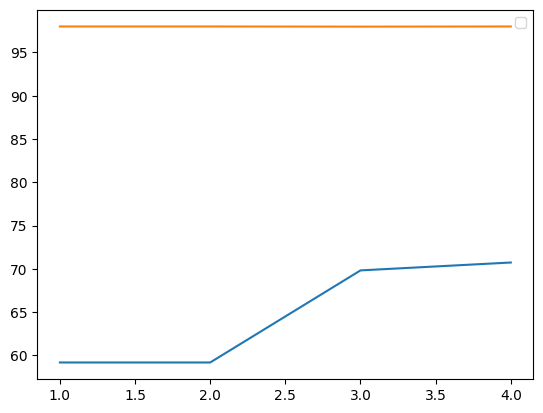

In [22]:
results = {'# of features': [], 'features_idx': [], 'SVM accuracy': [], 'MLP accuracy': []}
#for n_ft in range(1, len(X.columns)):
for n_ft in range(1, 5):
  # Apply PCA to X values
  scaler = StandardScaler()
  scaled_X = scaler.fit_transform(X)
  pca = PCA(0.80)
  #pca = PCA(n_components=1)
  # pca = PCA(n_components='m')
  pc_X= pca.fit_transform(scaled_X)
  pc_X_df = pd.DataFrame(data = pc_X, columns = ['PC' + str(i) for i in range(1, pca.n_components_ + 1)])
  scale_factor = 10
  scaled_pc_X = (pc_X * scale_factor).astype(int)
  Y = np.asarray(res['seizure'])
  feature_names = X.columns.tolist()

  # Finding the most important features
  explained_variance_ratio = pca.explained_variance_ratio_
  loadings = pca.components_ # each row reprensents a principal component

  # get the absolute value of the loading
  abs_load = np.abs(loadings)

  # get the weight of all the features from the PCA
  feature_importance = np.sum(abs_load, axis = 0)

  # sort the index of the feature importance in descending order
  # biggest features show up first
  sorted_idx = np.argsort(feature_importance)[::-1]

  # get n_ft most important features
  most_important_feature = sorted_idx[:n_ft]

  # get the new columns from the PCA
  new_columns = []
  ft_id = []
  for i in most_important_feature:
      new_columns.append(feature_names[i])
      name = str(feature_names[i])
      ft_id.append(name + ' (' + str(i) + ')' )
  new_df = res[new_columns]

  # scale new_df
  n_scaler = StandardScaler()
  n_scaled_X = scaler.fit_transform(new_df)

  # quantize to int
  scaled_n_X = (n_scaled_X * scale_factor).astype(int)

  # change back to df just for visualization
  n_scaled_df = pd.DataFrame(data = scaled_n_X, columns = [feature_names[i] for i in most_important_feature])

  # used_input = scaled_pc_X
  used_input = scaled_n_X
  X_train, X_test, y_train, y_test = train_test_split(used_input, Y, test_size = 0.2, random_state=0)

  acc_svm = svm(y_train, y_test, X_train, X_test)
  acc_mlp = mlp(y_train, y_test, X_train, X_test)

  # results = {'# of features': [], 'features': [], 'SVM accuracy': [], 'MLP accuracy': []}
  results['# of features'].append(n_ft)
  results['features_idx'].append(ft_id)
  results['SVM accuracy'].append(acc_svm)
  results['MLP accuracy'].append(acc_mlp)

  # f = open("pca.txt", "w")
  # f.write("scaled_X: " + str(scaled_X) + "\n\npc_X_df: " + str(pc_X_df) + "\n\nscaled_pc_X: " + str(scaled_pc_X) + "\n\nexplained_variance_ratio: " + str(explained_variance_ratio) + "\n\nloadings: " + str(loadings)+ "\n\nsorted_idx" + str(sorted_idx) + "\n\nnew_df: " + str(new_df))
  # f.close()

results_file = 'patient' + str(patient_num) + '_results.csv'
# fields = ['# of features', 'features_idx', 'SVM accuracy', 'MLP accuracy']

# with open(results_file, 'w') as f:
#     writer = csv.DictWriter(f, fieldnames=fields)

#     # writing headers (field names)
#     writer.writeheader()

#     # writing data rows
#     writer.writerows(results)

# Plot SVM and MLP accuracy as a function of the number of features used
plt.plot(results['# of features'], results['SVM accuracy'])
plt.plot(results['# of features'], results['MLP accuracy'])
plt.legend()
plt.show()

In [20]:
new_df

,P7-T7_kurtosis,T7-P7_kurtosis,P7-T7_skewness,T7-P7_skewness
0,0.592661,0.592661,-0.039233,0.039233
1,1.009830,1.009830,0.191775,-0.191775
2,1.427647,1.427647,0.006167,-0.006167
3,1.268856,1.268856,0.033464,-0.033464
4,1.304543,1.304543,0.063205,-0.063205
...,...,...,...,...
27448,-0.015922,-0.015922,-0.158114,0.158114
27449,-0.031645,-0.031645,-0.136759,0.136759
27450,0.187278,0.187278,-0.062660,0.062660
27451,0.312574,0.312574,-0.058167,0.058167


In [23]:
# Write key results (number of features, feature names and ID, and SVM/MLP accuracy) to CSV file
results_table = pd.DataFrame.from_dict(results, orient='index')
results_table.to_csv(results_file, index=False)